# Using a pretrained convnet
A pretrained network is a saved network (ie. weights & bias) that was previously trained on a large dataset. For instance, you might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images.

Demonstrate this method with cats vs dogs example.

VGG16 is a network structure that comes with keras.

- `weights`, to specify which weight to initialize the model from.
- `include_top`, which refers to include or not the densely-connected classifier on top of the network. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
- `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Feature Extraction with a pretrained convnet
Use the convolutional base as it is. Run my input through the base to get an output. Use the output as input to a standalone densely-connected classifier. Fast and cheap to run.


In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
"""
Now I have the output of convolutional base. Feed them into the densely-connected classifier
"""
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 0s 4ms/step - loss: 0.5904 - acc: 0.6730 - val_loss: 0.4363 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4190 - acc: 0.8110 - val_loss: 0.3564 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3485 - acc: 0.8600 - val_loss: 0.3198 - val_acc: 0.8670
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3165 - acc: 0.8680 - val_loss: 0.2952 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2818 - acc: 0.8850 - val_loss: 0.2901 - val_acc: 0.8800
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2596 - acc: 0.8975 - val_loss: 0.2687 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2438 - acc: 0.9085 - val_loss: 0.2602 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

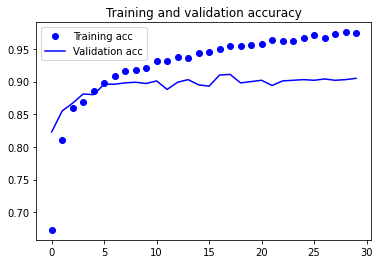

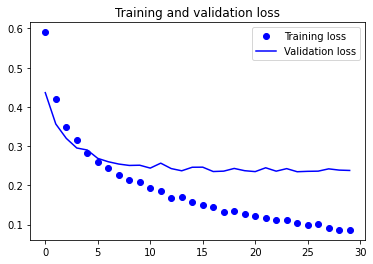

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()